In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from g2aero.yaml_info import YamlInfo
from g2aero.Grassmann_interpolation import GrassmannInterpolator
from g2aero.transform import TransformBlade

plot_folder = os.path.join(os.getcwd(), 'plots_how_to_interpolate', )
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

# How to use Grassmann Interpolation

*Input to create interpolator*:
- 2D cross sections 
- locations of these cross sections along the blade span

*Requirements*:
- 2D cross sections parallel to each other 
- Equal number of landmarks (points defining cross section in 2D)
- Normalized location along the span $\eta\in[0, 1]$

## Simple demonstration

### Reading blade data from .yaml file
First we need to read the IEA-15-240-RWT.yaml file with given blade information. In this notebook we consider only interpolation between the given shapes and do not confider the transformation of the blade after interpolation due to twist, chord scaling and out-of-plane rotation. Thus the blade is defined only by:
- several 2D nominal cross sections given in local coordinates ($x_{loc}, y_{loc}$);
- locations of these cross sections along the blade span (Normalized span location is given by $\eta \in [0, 1]$).




Text(0.5, 1.0, 'Given nominal shapes')

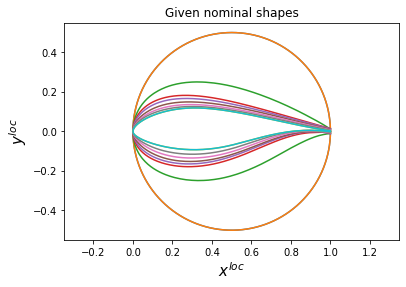

In [2]:
# shapes_filename = os.path.join(os.getcwd(), "data", "blades_yamls", "nrel5mw_ofpolars.yaml")
shapes_filename = os.path.join(os.getcwd(), "data", "blades_yamls", "IEA-15-240-RWT.yaml")
Blade = YamlInfo(shapes_filename, n_landmarks=401)
eta_nominal = Blade.eta_nominal
xy_nominal = Blade.xy_landmarks

fig, ax = plt.subplots(1, 1)
for i, xy in enumerate(Blade.xy_landmarks):
    ax.plot(xy[:, 0], xy[:, 1])
ax.axis('equal')
ax.set_xlabel(r'$x^{loc}$', fontsize=15)
ax.set_ylabel(r'$y^{loc}$', fontsize=15)
ax.set_title('Given nominal shapes')

In [3]:
# from IPython.display import HTML
# plot_3d_blade_nominal(xy_nominal, eta_nominal, plot_folder, 'nominal_shapes_3D.html')

### Interpolation
1. First we need to create interpolator object using these spanwise locations and correcponding 2D cross sections. 
2. Then we create array of spanwise locations where we want to get new interpolated cross sections 
3. Pass array of desired locations to created interpolator to get interpolated shapes

Text(0.5, 1.0, 'Interpolated shapes')

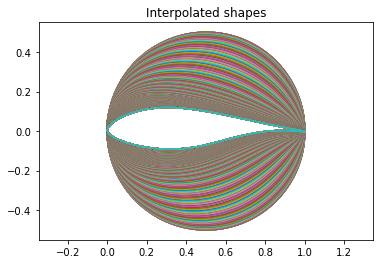

In [4]:
GrInterp = GrassmannInterpolator(eta_nominal, xy_nominal)
eta_span = np.linspace(0, 1, 500)
phys_crosssections = GrInterp(eta_span)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, xy in enumerate(phys_crosssections):
    ax.plot(xy[:, 0], xy[:, 1])
ax.axis('equal')
ax.set_title("Interpolated shapes")

## How Grassmanian interpolation works

### 1. Get shapes on Grassmann

Shapes in physical space are given by a $n$ landmarks $\mathbf{x} = [x_{loc}, y_{loc}]^T$. Thus, a shape can be represented by $n\times 2$ matrix $X = [\math]^T$.
The nominal shapes are Landmark-Affine standardized to represent a shape on Grassmannian as following:
$$\mathbf{x}_{gr}=\frac{1}{\sqrt{n-1}}M^{-1}(\mathbf{x}-B),$$
where $B = \mathbf{1} \rm{diag}(\mathbf{b})$ with $\mathbf{1}$ in $n\times 2$ matrix consisting of all ones and $\rm{diag}(\mathbf{b})$ is the $2\times 2$ matrix with $b_1, b_2)$ on the diagonal. is the center of mass of a shape and $M^{-1}$ is $2\times2$ matrix calculated using SVD as
$$M^{-1} = (1. / s) U^T$$



This shapes can be accessed in GrassmannInterpolator as shown below. Also if we want our interpolator to return not only physical interpolated shapes but interpolated shapes on Grassmannian as well, we can pass argument `grassmann=True` to the interpolator.

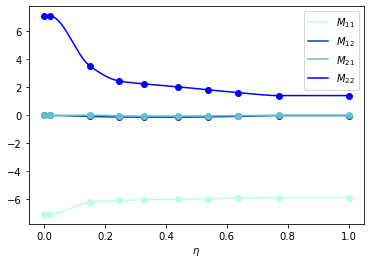

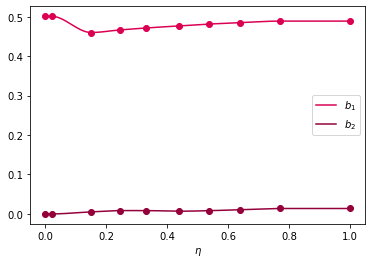

In [5]:
M = GrInterp.interpolator_M
b = GrInterp.interpolator_b
    
colors = ['#b9ffe7', '#00429d', '#64c0d0', 'b']
labels = [r'$M_{11}$', r'$M_{12}$', r'$M_{21}$', r'$M_{22}$']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(4):
    ax.plot(eta_span, M(eta_span).reshape(-1, 4)[:, i], '-', color=colors[i], label=labels[i])
    ax.plot(eta_nominal, M(eta_nominal).reshape(-1, 4)[:, i], 'o', color=colors[i])
ax.set_xlabel(r'$\eta$')
# ax.set_title('M interpolation')
ax.legend(loc=0)
fig.savefig(os.path.join(plot_folder, 'M.pdf'))


colors = ['#db0052', '#93003a']
labels = [r'$b_1$', r'$b_2$']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(2):
    ax.plot(eta_span, b(eta_span)[:, i], '-', color=colors[i], label=labels[i])
    ax.plot(eta_nominal, b(eta_nominal)[:, i], 'o', color=colors[i])
ax.set_xlabel(r'$\eta$')
# ax.set_title('b interpolation')
ax.legend(loc=0)
fig.savefig(os.path.join(plot_folder, 'b.pdf'))

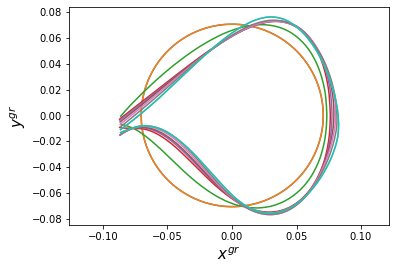

In [6]:
nominal_gr = GrInterp.xy_grassmann

fig = plt.figure()
ax = plt.axes()
for i, xy in enumerate(nominal_gr):
    ax.plot(xy[:, 0], xy[:, 1])
ax.axis('equal')
ax.set_xlabel(r'$x^{gr}$', fontsize=15)
ax.set_ylabel(r'$y^{gr}$', fontsize=15)
fig.subplots_adjust(left=0.16)
fig.savefig(os.path.join(plot_folder, 'grassmann_shapes.pdf'))

# fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# for i, xy in enumerate(nominal_gr):
#     ax[0].plot(xy[:, 0], xy[:, 1])
# ax[0].axis('equal')
# ax[0].set_xlabel(r'$x_{gr}$', fontsize=15)
# ax[0].set_ylabel(r'$y_{gr}$', fontsize=15)
# ax[0].set_title("nominal shapes on Grassmannian")

# phys_crosssections, gr_crosssections = GrInterp(eta_span, grassmann=True)
# for i, xy in enumerate(gr_crosssections):
#     ax[1].plot(xy[:, 0], xy[:, 1])
# ax[1].set_xlabel(r'$x_{gr}$', fontsize=15)
# ax[1].set_ylabel(r'$y_{gr}$', fontsize=15)
# ax[1].axis('equal')
# ax[1].set_title("Interpolated shapes on Grassmanian")

In [7]:
### 

In [8]:
print('Grassmann')
Grassmann = GrassmannInterpolator(eta_nominal, xy_nominal)
M = Grassmann.interpolator_M
b = Grassmann.interpolator_b

Grassmann


Checking that we can restore nominal shapes after Grassmann interpolation


Text(0.5, 1.0, 'Grassmann shapes')

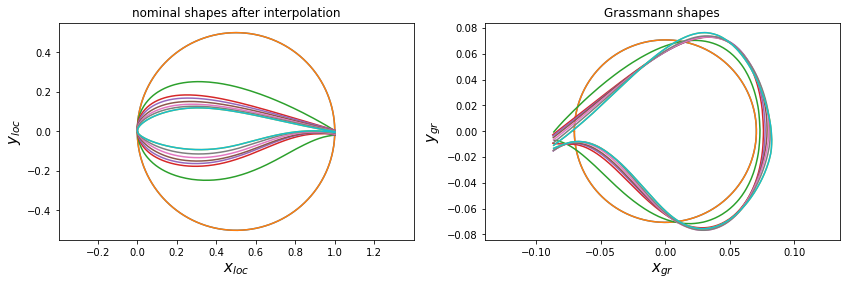

In [9]:
print('Checking that we can restore nominal shapes after Grassmann interpolation')
Grassmann = GrassmannInterpolator(eta_nominal, xy_nominal)
phys_crosssections, gr_crosssections = Grassmann(eta_nominal, grassmann=True)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for i, xy in enumerate(phys_crosssections):
    ax[0].plot(xy[:, 0], xy[:, 1])
ax[0].axis('equal')
ax[0].set_xlabel(r'$x_{loc}$', fontsize=15)
ax[0].set_ylabel(r'$y_{loc}$', fontsize=15)
ax[0].set_title("nominal shapes after interpolation")

for i, xy in enumerate(gr_crosssections):
    ax[1].plot(xy[:, 0], xy[:, 1])
ax[1].set_xlabel(r'$x_{gr}$', fontsize=15)
ax[1].set_ylabel(r'$y_{gr}$', fontsize=15)
ax[1].axis('equal')
ax[1].set_title("Grassmann shapes")


Grassmann


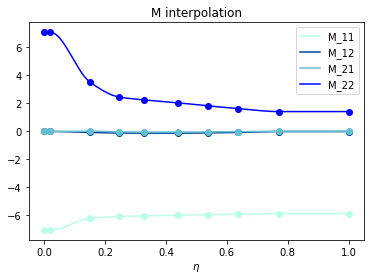

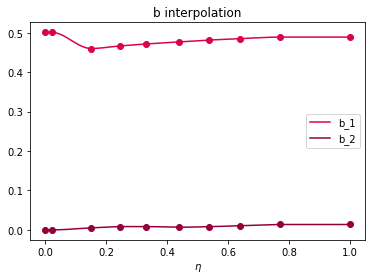

In [10]:
print('Grassmann')
Grassmann = GrassmannInterpolator(eta_nominal, xy_nominal)
M = Grassmann.interpolator_M
b = Grassmann.interpolator_b
    
colors = ['#b9ffe7', '#00429d', '#64c0d0', 'b']
labels = ['M_11', 'M_12', 'M_21', 'M_22']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(4):
    ax.plot(eta_span, M(eta_span).reshape(-1, 4)[:, i], '-', color=colors[i], label=labels[i])
    ax.plot(eta_nominal, M(eta_nominal).reshape(-1, 4)[:, i], 'o', color=colors[i])
ax.set_xlabel(r'$\eta$')
ax.set_title('M interpolation')
ax.legend(loc=0)
fig.savefig(os.path.join(plot_folder, 'M.pdf'))


colors = ['#db0052', '#93003a']
labels = ['b_1', 'b_2']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(2):
    ax.plot(eta_span, b(eta_span)[:, i], '-', color=colors[i], label=labels[i])
    ax.plot(eta_nominal, b(eta_nominal)[:, i], 'o', color=colors[i])
ax.set_xlabel(r'$\eta$')
ax.set_title('b interpolation')
ax.legend(loc=0)
fig.savefig(os.path.join(plot_folder, 'b.pdf'))

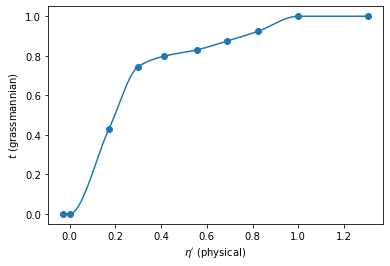

In [11]:
eta_span_scaled = Grassmann.eta_scaled(eta_span)
fig = plt.figure()
ax = plt.gca()
ax.scatter(Grassmann.eta_nominal_scaled, Grassmann.t_nominal)
ax.plot(eta_span_scaled, Grassmann.interpolator_cdf(eta_span_scaled))
ax.set_xlabel(r'$\eta^{\prime}$ (physical)')
ax.set_ylabel(r'$t$ (grassmannian)')
fig.savefig(os.path.join(plot_folder, 'cdf.pdf'))

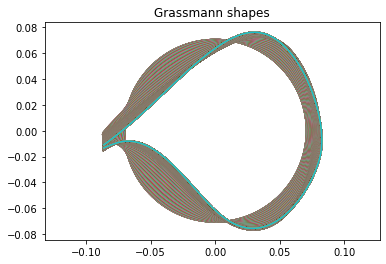

In [12]:
gr_span = np.empty((len(eta_span), Grassmann.n_landmarks, 2))
phys_span = np.empty((len(eta_span), Grassmann.n_landmarks, 2))
for i, eta in enumerate(eta_span):
    phys_span[i], gr_span[i] = Grassmann(eta, grassmann=True)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, xy in enumerate(gr_span):
    ax.plot(xy[:, 0], xy[:, 1])
ax.axis('equal')
ax.set_title("Grassmann shapes")
fig.savefig(os.path.join(plot_folder, 'grassmann_span.pdf'))
    
gr_nominal = np.empty((len(eta_nominal), Grassmann.n_landmarks, 2))
phys_nominal = np.empty((len(eta_nominal), Grassmann.n_landmarks, 2))
for i, eta in enumerate(eta_nominal):
    phys_nominal[i], gr_nominal[i] = Grassmann(eta, grassmann=True)

In [13]:
from IPython.display import HTML
anim = SubplotAnimation(Grassmann, Grassmann.eta_scaled(eta_span), phys_nominal, gr_nominal, gr_span, phys_span)
# plt.close()
# HTML(anim.to_jshtml())
# anim.save(os.path.join(plot_folder, 'animation.mpeg'), writer='ffmpeg', dpi=256)
writergif = animation.PillowWriter(fps=10) 
anim.save(os.path.join(plot_folder, 'animation.gif'), writer=writergif)
# a = HTML(anim.to_jshtml())
# html = a.data
# with open(os.path.join(plot_folder, 'animation.html'), 'w') as f:
#     f.write(html)
anim

NameError: name 'SubplotAnimation' is not defined

In [ ]:
import plotly.graph_objects as go
from matplotlib.lines import Line2D

def plot_3d_blade(shapes, eta_span, shapes_nominal, eta_nominal, plot_folder, name):
    scale = 20
    N_eta_skp = 1
    N_arc_skp = 25
    line_b = go.scatter3d.Line(color = "#1f77b4",width = 1.)
    line_m = go.scatter3d.Line(color = "#db0052",width = 4.)
    data = []
    
#     TE_line_u = shapes[:, 0, :]
#     TE_line_l = shapes[:, shapes.shape[1]-1, :]
#     for i, shape in enumerate(shapes):
#         eta_span_z = np.repeat(eta_span[i], len(shape))*scale
#         data.append(go.Scatter3d(x=eta_span_z, y=shape[:, 0], z=shape[:, 1], mode='lines', line=line))
        
#     data.append(go.Scatter3d(x=eta_span*scale, y=TE_line_u[:, 0], z=TE_line_u[:, 1], mode='lines', line=line))
#     data.append(go.Scatter3d(x=eta_span*scale, y=TE_line_l[:, 0], z=TE_line_l[:, 1], mode='lines', line=line))
#     data.append(go.Scatter3d(x=eta_span_z, y=shapes[:, 0, 0], z=shapes[:, 0, 1], mode='lines', line=line))
    
    # Plot Grassmann interpolator cross section refinements    
    for i in range(0, int((shapes.shape[0])), N_eta_skp):
        eta_span_z = np.repeat(eta_span[i], shapes.shape[1])*scale
        data.append(go.Scatter3d(x=eta_span_z, y=shapes[i, :, 0], z=shapes[i, :, 1], mode='lines', line=line_b))
    
    # Plot tip
    i = int((shapes.shape[0]))-1
    eta_span_z = np.repeat(eta_span[i], shapes.shape[1])*scale
    data.append(go.Scatter3d(x=eta_span_z, y=shapes[i, :, 0], z=shapes[i, :, 1], 
                             mode='lines', line=line_b))
    
    # Plot span-wise landmarks
    span_line = np.empty((shapes.shape[1], shapes.shape[0], 2))
    for j in range(0, int((shapes.shape[1])), N_arc_skp):
        span_line[j] = shapes[:, j, :]
        data.append(go.Scatter3d(x=eta_span*scale, y=span_line[j, :, 0], z=span_line[j, :, 1], 
                                 mode='lines', line=line_b))
    
    
    # Plot nominal cross sections
    for i in range(0, int(shapes_nominal.shape[0])):
        eta = np.repeat(eta_nominal[i], shapes_nominal.shape[1])*scale
        nominal_x = shapes_nominal[i, :, 0].flatten()
        nominal_y = shapes_nominal[i, :, 1].flatten()
        data.append(go.Scatter3d(x=eta, y=nominal_x, z=nominal_y, mode='lines', line=line_m))
    
    fig = go.Figure(data=data)                     
    fig.update_layout(scene_aspectmode='data')
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
    fig.write_html(os.path.join(plot_folder, name))
    fig.show()

    
plot_3d_blade(phys_span, eta_span, phys_nominal, eta_nominal, plot_folder, 'phys_blade.html')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation
import plotly.graph_objects as go
mpl.rcParams['animation.embed_limit'] = 2**128

class SubplotAnimation(animation.TimedAnimation):
    def __init__(self, grassmann, eta_span_scaled, phys_nominal, gr_nominal, geodesic_gr, geodesic_phys, delay=150):

        font = {'family': 'times',
                'weight': 'bold',
                'size': 22}

        mpl.rc('font', **font)
        self.n = geodesic_gr.shape[0]
        self.n_shapes = phys_nominal.shape[0]
        self.geodesic_gr = geodesic_gr
        self.geodesic_phys = geodesic_phys
        self.x_phys = phys_nominal
        self.x_gr = gr_nominal
        self.eta_nominal = grassmann.eta_nominal_scaled
        self.eta_span = eta_span_scaled
        self.t_nominal = grassmann.t_nominal
        self.t_span = grassmann.interpolator_cdf(eta_span_scaled)

        gs_kw = dict(width_ratios=[1.5, 1, 1])
        fig, ax = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True, gridspec_kw=gs_kw)

        # Distances
        ax[0].axis('off')
        ax[0].set_aspect(0.25)
        ax[0].set_title('distance')
        ax[0].axis(ymin=-1, ymax=2)

        ax[0].add_artist(Line2D(np.linspace(self.eta_nominal[0], self.eta_nominal[-1], 1000), np.ones(1000), color='b'))
        ax[0].add_artist(Line2D(np.linspace(0, 1, 1000), np.zeros(1000), color='b'))
        ax[0].scatter(self.t_nominal, np.zeros(self.n_shapes), marker='o',
                      edgecolors='b', facecolor='None', s=50, linewidth=1)
        ax[0].scatter(self.eta_nominal, np.ones(self.n_shapes), marker='o',
                      edgecolors='b', facecolor='None', s=50, linewidth=1)
        ax[0].text(0.1, 1.2, 'physical')
        ax[0].text(0.1, 0.22, 'grassmann')

        # physical
        ax[1].axis('off')
        ax[1].axis('equal')
        ax[1].set_title('physical')
#         ax[1].axis(xmin=-3.5, xmax=4.5, ymin=-5., ymax=4)
        ax[1].axis(xmin=-0.3, xmax=1.3, ymin=-0.8, ymax=0.8)
        # grassmann
        ax[2].axis('off')
        ax[2].axis('equal')
        ax[2].set_title('grassmann')
        ax[2].axis(xmin=-0.12, xmax=0.12, ymin=-0.12, ymax=0.12)

        self.k_line = Line2D([], [], color='k')
        self.moving_dot = Line2D([], [], color='k', marker='o', markeredgecolor='k')

        self.g_dot = Line2D([], [], color='g', marker='o', markeredgecolor='g')
        self.r_dot = Line2D([], [], color='r', marker='o', markeredgecolor='r')
        ax[0].add_line(self.g_dot)
        ax[0].add_line(self.r_dot)
        ax[0].add_line(self.k_line)
        ax[0].add_line(self.moving_dot)

        self.k_line1 = Line2D([], [], color='k')
        self.moving_dot1 = Line2D([], [], color='k', marker='o', markeredgecolor='k')
        self.g_dot1 = Line2D([], [], color='g', marker='o', markeredgecolor='g')
        self.r_dot1 = Line2D([], [], color='r', marker='o', markeredgecolor='r')
        ax[0].add_line(self.g_dot1)
        ax[0].add_line(self.r_dot1)
        ax[0].add_line(self.k_line1)
        ax[0].add_line(self.moving_dot1)

        self.m_dot = Line2D([], [], color='m', marker='o', markeredgecolor='m')
        self.phys_shape = Line2D([], [], color='g', linewidth=2)
        self.phys_shape_next = Line2D([], [], color='r', linewidth=2)
        self.phys_moving = Line2D([], [], color='k', linewidth=1)
        ax[1].add_line(self.m_dot)
        ax[1].add_line(self.phys_shape)
        ax[1].add_line(self.phys_shape_next)
        ax[1].add_line(self.phys_moving)

        self.gr_shape = Line2D([], [], color='g', linewidth=2)
        self.gr_shape_next = Line2D([], [], color='r', linewidth=2)
        self.gr_moving = Line2D([], [], color='k', linewidth=1)
        ax[2].add_line(self.gr_shape)
        ax[2].add_line(self.gr_shape_next)
        ax[2].add_line(self.gr_moving)

        animation.TimedAnimation.__init__(self, fig, interval=delay, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        j = np.where(self.eta_span[i] >= self.eta_nominal)[0][-1]
        j_prev = np.where(self.eta_span[i-1] >= self.eta_nominal)[0][-1]
        if i == 0:
            j_prev = -1
        if j > j_prev:
            self.g_dot.set_data(self.t_nominal[j], 0)
            self.g_dot1.set_data(self.eta_nominal[j], 1)
            self.phys_shape.set_data(self.x_phys[j, :, 0], self.x_phys[j, :, 1])
            self.gr_shape.set_data(self.x_gr[j, :, 0], self.x_gr[j, :, 1])
            if j < self.n_shapes - 1:
                self.r_dot.set_data(self.t_nominal[j + 1], 0)
                self.r_dot1.set_data(self.eta_nominal[j + 1], 1)
                self.phys_shape_next.set_data(self.x_phys[j+1, :, 0], self.x_phys[j+1, :, 1])
                self.gr_shape_next.set_data(self.x_gr[j+1, :, 0], self.x_gr[j+1, :, 1])

        # grassmann line

        self.k_line.set_data(self.t_span[:i], np.zeros(i))
        self.moving_dot.set_data(self.t_span[i], 0)
        # physical line
        self.k_line1.set_data(self.eta_span[:i], np.ones(i))
        self.moving_dot1.set_data(self.eta_span[i], 1)

        # circles
        self.m_dot.set_data(self.geodesic_phys[i, 0, 0], self.geodesic_phys[i, 0, 1])
        self.phys_moving.set_data(self.geodesic_phys[i, :, 0], self.geodesic_phys[i, :, 1])
        self.gr_moving.set_data(self.geodesic_gr[i, :, 0], self.geodesic_gr[i, :, 1])

        self._drawn_artists = [self.k_line, self.moving_dot, self.g_dot, self.r_dot,
                               self.k_line1, self.moving_dot1, self.g_dot1, self.r_dot1,
                               self.phys_shape, self.phys_shape_next, self.phys_moving,
                               self.gr_shape, self.gr_shape_next, self.gr_moving, self.m_dot]

    def new_frame_seq(self):
        return iter(range(self.n))

    def _init_draw(self):
        lines = [self.moving_dot, self.k_line, self.g_dot, self.r_dot,
                 self.moving_dot1, self.k_line1, self.g_dot1, self.r_dot1,
                 self.phys_shape, self.phys_shape_next, self.phys_moving,
                 self.gr_shape, self.gr_shape_next, self.gr_moving, self.m_dot]
        for l in lines:
            l.set_data([], [])